# Supplmentary figures

In [1]:
using DifferentialEquations
using ModelingToolkit
using MitochondrialDynamics
using MitochondrialDynamics: GlcConst, VmaxPDH, pHleak, VmaxF1, VmaxETC, J_ANT, J_O2
using MitochondrialDynamics: G3P, Pyr, NADH_c, NADH_m, Ca_c, Ca_m, ΔΨm, ATP_c, ADP_c, AMP_c, degavg, t, x
using MitochondrialDynamics.Utils: second, μM, mV, mM, Hz, minute

import PyPlot as plt
rcParams = plt.PyDict(plt.matplotlib."rcParams")
rcParams["font.size"] = 14
# rcParams["font.sans-serif"] = "Arial"
# rcParams["font.family"] = "sans-serif"

isapprox(IntervalSets.AbstractInterval{T} where T, IntervalSets.AbstractInterval{T} where T) in module IntervalSets at C:\Users\sosiristseng\.julia\packages\IntervalSets\voJZA\src\IntervalSets.jl:146 overwritten in module DomainSets at C:\Users\sosiristseng\.julia\packages\DomainSets\aafhp\src\domains\interval.jl:52.
  ** incremental compilation may be fatally broken for this module **



14

## Figure S1

Supplementary figure 1: Response to elevated glucose concentrations in steps.

In [2]:
function glc_step(t)
    return 5.0mM * (1 + (t >= 20minute) + (t >= 40minute))
end

tend = 60minute
@named sys = make_model(; glcrhs=glc_step(t))
prob = ODEProblem(sys, [], tend)
sol = solve(prob, tstops=[20minute, 40minute]);

In [3]:
function plot_figs1(
    sol;
    figsize=(10, 10),
    tspan=(0.0, 60minute),
    tight=true,
    grid=true
)
    ts = sol.t
    tsm = ts ./ 60
    g3p = sol.(ts, idxs=G3P) .* 1000
    pyr = sol.(ts, idxs=Pyr) .* 1000
    nadh_c = sol.(ts, idxs=NADH_c) .* 1000
    nadh_m = sol.(ts, idxs=NADH_m) .* 1000
    ca_c = sol.(ts, idxs=Ca_c) .* 1000
    ca_m = sol.(ts, idxs=Ca_m) .* 1000
    atp_c = sol.(ts, idxs=ATP_c) .* 1000
    adp_c = sol.(ts, idxs=ADP_c) .* 1000
    amp_c = sol.(ts, idxs=AMP_c) .* 1000
    dpsi = sol.(ts, idxs=ΔΨm) .* 1000
    k = sol.(ts, idxs=degavg)
    x1 = sol.(ts, idxs=x[1])
    x2 = sol.(ts, idxs=x[2])
    x3 = sol.(ts, idxs=x[3])

    fig, ax = plt.subplots(3, 3; figsize)

    ax[1, 1].plot(tsm, g3p)
    ax[1, 1].set(title="(A) G3P (μM)", ylim=(0.0, 8.0))

    ax[1, 2].plot(tsm, pyr)
    ax[1, 2].set(title="(B) Pyruvate (μM)", ylim=(0.0, 80.0))

    ax[1, 3].plot(tsm, ca_c, label="cyto")
    ax[1, 3].plot(tsm, ca_m, label="mito")
    ax[1, 3].set(title="(C) Calcium (μM)")
    ax[1, 3].legend()

    ax[2, 1].plot(tsm, nadh_c, label="cyto")
    ax[2, 1].plot(tsm, nadh_m, label="mito")
    ax[2, 1].set(title="(D) NADH (μM)")
    ax[2, 1].legend()

    ax[2, 2].plot(tsm, atp_c, label="ATP")
    ax[2, 2].plot(tsm, adp_c, label="ADP")
    ax[2, 2].plot(tsm, amp_c, label="AMP")
    ax[2, 2].set(title="(E) Adenylates (μM)")
    ax[2, 2].legend()

    ax[2, 3].plot(tsm, atp_c ./ adp_c)
    ax[2, 3].set(title="(F) ATP:ADP", ylim=(0, 40))

    ax[3, 1].plot(tsm, dpsi)
    ax[3, 1].set(title="(G) ΔΨ (mV)", ylim=(80, 150), xlabel="Time (seconds)")

    ax[3, 2].plot(tsm, x1, label="X1")
    ax[3, 2].plot(tsm, x2, label="X2")
    ax[3, 2].plot(tsm, x3, label="X3")
    ax[3, 2].set(title="(H) Mitochondrial nodes", xlabel="Time (seconds)")
    ax[3, 2].legend()

    ax[3, 3].plot(tsm, k)
    ax[3, 3].set(title="(I) Average Node Degree", xlabel="Time (seconds)")

    if grid 
        for a in ax
            a.grid()
        end
    end

    fig.set_tight_layout(tight)
    return fig
end

plot_figs1 (generic function with 1 method)

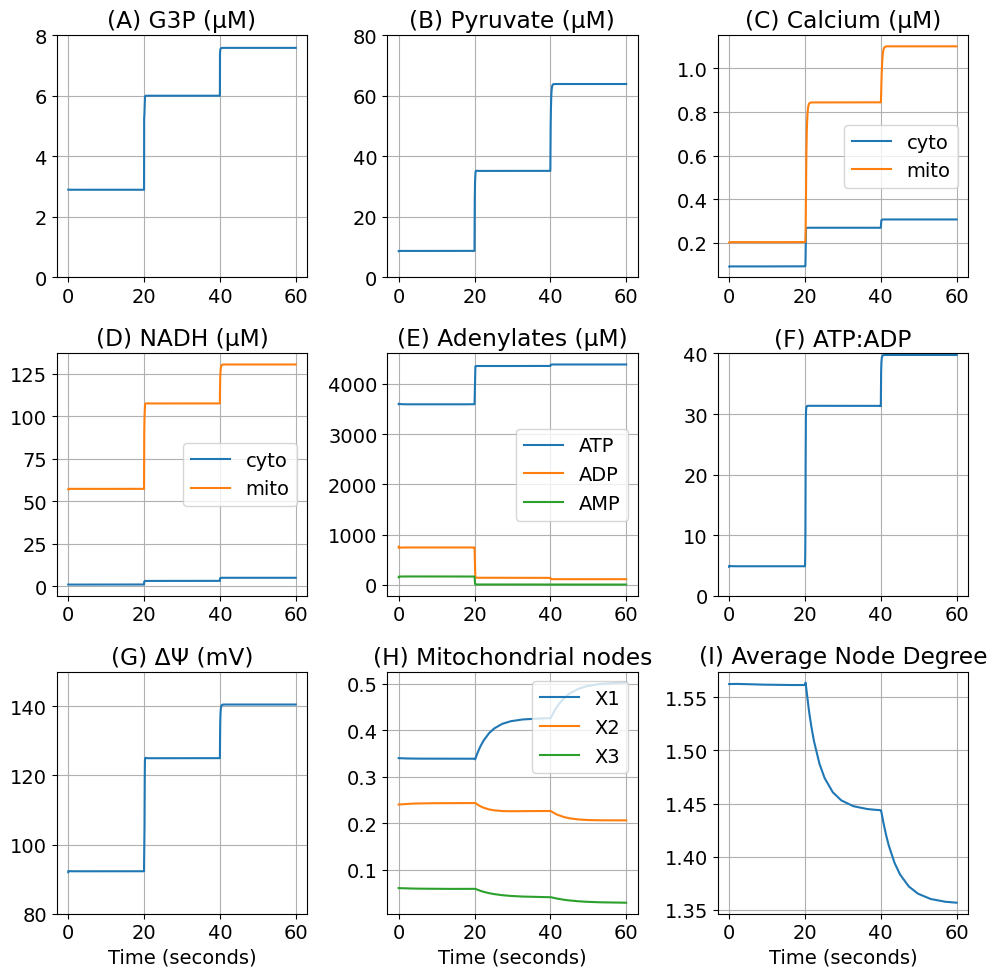

In [4]:
figs1 = plot_figs1(sol)

In [5]:
# Uncomment if tif file is required
figs1.savefig("FigS1.tif", dpi=300, format="tiff", pil_kwargs=Dict("compression" => "tiff_lzw"))

## Figure S2 : DM step response

Response to adding glucose in healthy and DM cells.

In the diabetic parameter set. We adjusted

- PDH capacity
- ETC capacity
- F1 synthase capacity
- Proton leak rate

In [6]:
pidx = Dict(k => i for (i, k) in enumerate(parameters(sys)))

function make_dm_prob(prob; rPDH=0.5, rETC=0.75, rHL=1.4, rF1=0.5)
    p = copy(prob.p)
    idxVmaxPDH = pidx[VmaxPDH]
    idxpHleak = pidx[pHleak]
    idxVmaxF1 = pidx[VmaxF1]
    idxVmaxETC = pidx[VmaxETC]
    p[idxVmaxPDH] *= rPDH
    p[idxpHleak] *= rHL
    p[idxVmaxF1] *= rF1
    p[idxVmaxETC] *= rETC
    return remake(prob, p=p)
end

make_dm_prob (generic function with 1 method)

In [7]:
probDM = make_dm_prob(prob)
solDM = solve(probDM, tstops=[20minute, 40minute]);

In [8]:
function plot_figs2(sol, solDM;
    tspan=(0.0, 60minute),
    density=301,
    figsize=(12, 12),
    labels=["Baseline", "Diabetic"],
    tight=true
)
    ts = range(tspan[1], tspan[2], length=density)
    tsm = ts ./ 60

    g3p = sol.(ts, idxs=G3P) .* 1000
    pyr = sol.(ts, idxs=Pyr) .* 1000
    nadh_c = sol.(ts, idxs=NADH_c) .* 1000
    nadh_m = sol.(ts, idxs=NADH_m) .* 1000
    ca_c = sol.(ts, idxs=Ca_c) .* 1000
    ca_m = sol.(ts, idxs=Ca_m) .* 1000
    atp_c = sol.(ts, idxs=ATP_c) .* 1000
    adp_c = sol.(ts, idxs=ADP_c) .* 1000
    td = atp_c ./ adp_c
    dpsi = sol.(ts, idxs=ΔΨm) .* 1000
    k = sol.(ts, idxs=degavg)

    g3pDM = solDM.(ts, idxs=G3P) .* 1000
    pyrDM = solDM.(ts, idxs=Pyr) .* 1000
    nadh_cDM = solDM.(ts, idxs=NADH_c) .* 1000
    nadh_mDM = solDM.(ts, idxs=NADH_m) .* 1000
    ca_cDM = solDM.(ts, idxs=Ca_c) .* 1000
    ca_mDM = solDM.(ts, idxs=Ca_m) .* 1000
    atp_cDM = solDM.(ts, idxs=ATP_c) .* 1000
    adp_cDM = solDM.(ts, idxs=ADP_c) .* 1000
    tdDM = atp_cDM ./ adp_cDM
    dpsiDM = solDM.(ts, idxs=ΔΨm) .* 1000
    kDM = solDM.(ts, idxs=degavg)

    fig, ax = plt.subplots(3, 3; figsize)

    ax[1, 1].plot(tsm, g3p, label=labels[1])
    ax[1, 1].plot(tsm, g3pDM, label=labels[2])
    ax[1, 1].set(ylabel="G3P (μM)")
    ax[1, 1].set_title("(A)", loc="left")

    ax[1, 2].plot(tsm, pyr, label=labels[1])
    ax[1, 2].plot(tsm, pyrDM, label=labels[2])
    ax[1, 2].set(ylabel="Pyruvate (μM)")
    ax[1, 2].set_title("(B)", loc="left")

    ax[1, 3].plot(tsm, nadh_c, label=labels[1])
    ax[1, 3].plot(tsm, nadh_cDM, label=labels[2])
    ax[1, 3].set(ylabel="Cytosolic NADH (μM)")
    ax[1, 3].set_title("(C)", loc="left")

    ax[2, 1].plot(tsm, nadh_m, label=labels[1])
    ax[2, 1].plot(tsm, nadh_mDM, label=labels[2])
    ax[2, 1].set(ylabel="Mitochondrial NADH (μM)")
    ax[2, 1].set_title("(D)", loc="left")

    ax[2, 2].plot(tsm, ca_c, label=labels[1])
    ax[2, 2].plot(tsm, ca_cDM, label=labels[2])
    ax[2, 2].set(ylabel="Cytosolic Calcium (μM)")
    ax[2, 2].set_title("(E)", loc="left")

    ax[2, 3].plot(tsm, ca_m, label=labels[1])
    ax[2, 3].plot(tsm, ca_mDM, label=labels[2])
    ax[2, 3].set(ylabel="Mitochondrial Calcium (μM)")
    ax[2, 3].set_title("(F)", loc="left")

    ax[3, 1].plot(tsm, td, label=labels[1])
    ax[3, 1].plot(tsm, tdDM, label=labels[2])
    ax[3, 1].set(ylabel="ATP:ADP")
    ax[3, 1].set_title("(G)", loc="left")

    ax[3, 2].plot(tsm, dpsi, label=labels[1])
    ax[3, 2].plot(tsm, dpsiDM, label=labels[2])
    ax[3, 2].set(ylabel="ΔΨm (mV)")
    ax[3, 2].set_title("(H)", loc="left")

    ax[3, 3].plot(tsm, k, label=labels[1])
    ax[3, 3].plot(tsm, kDM, label=labels[2])
    ax[3, 3].set(ylabel="Average Node Degree")
    ax[3, 3].set_title("(I)", loc="left")

    for a in ax
        a.grid()
        a.legend()
    end

    fig.set_tight_layout(tight)
    return fig
end

plot_figs2 (generic function with 1 method)

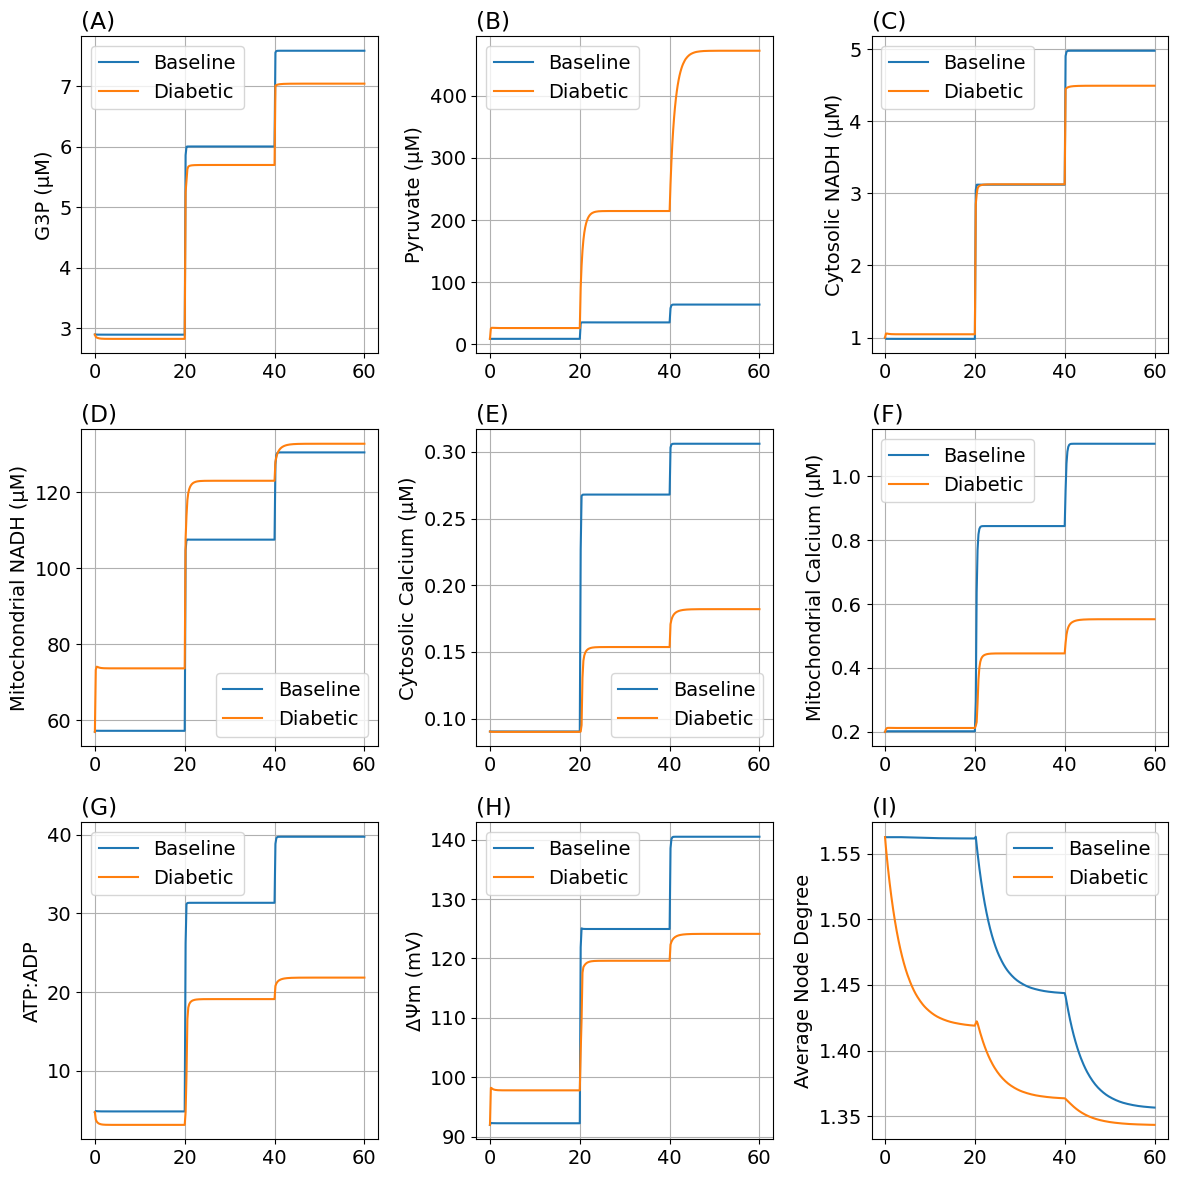

In [9]:
figs2 = plot_figs2(sol, solDM)

In [10]:
# Uncomment if pdf file is required
figs2.savefig("FigS2.tif", dpi=300, format="tiff", pil_kwargs=Dict("compression" => "tiff_lzw"))

## Figure S3

Changes in response to both glucose stimulation and chemical agents.

Using the Glucose-Oligomycin-FCCP protocol.

In [11]:
add_glucose(t) = 5mM + 15mM * (t >= 20minute)
add_oligomycin(t) = 1.0 - 0.95 * (t >= 40minute)
add_rotenone(t) = 1.0 - 0.95 * (t >= 60minute)
add_fccp(t) = 1.0 + 9.0 * (t >= 60minute)

add_fccp (generic function with 1 method)

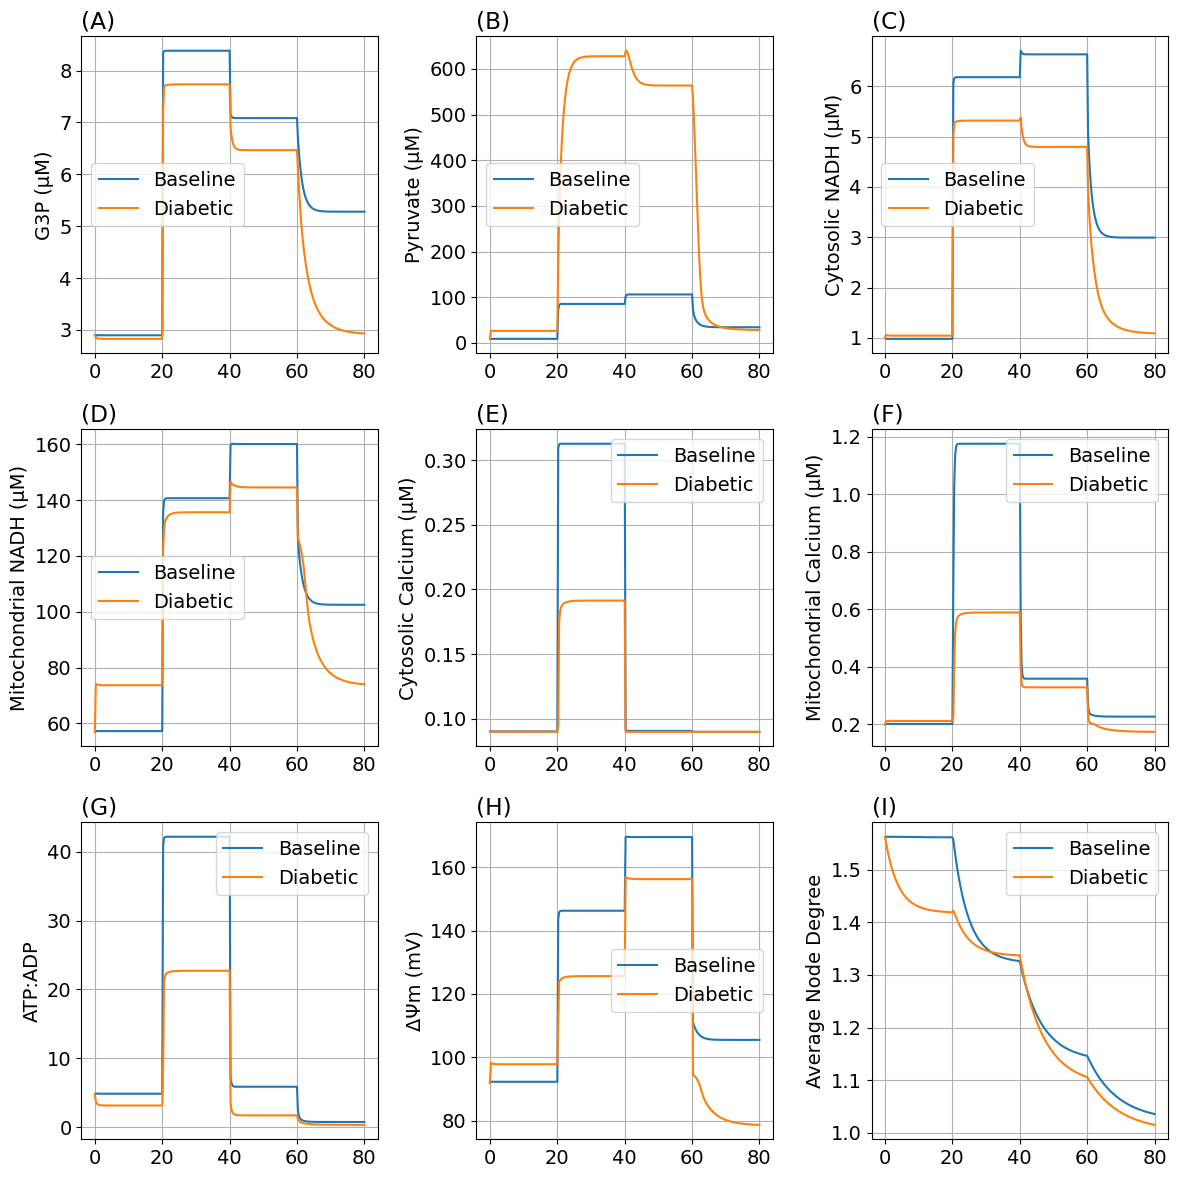

In [12]:
tend = 80minute

@named syss3 = make_model(;
    glcrhs=add_glucose(t),
    rf1=add_oligomycin(t),
    rhleak=add_fccp(t)
)

probs3 = ODEProblem(syss3, [], tend)
probs3DM = make_dm_prob(probs3; rPDH=0.5, rETC=0.75, rHL=1.4, rF1=0.5)

tstops = [20minute, 40minute, 60minute]

sols3 = solve(probs3; tstops)
solDMs3 = solve(probs3DM; tstops)

figs3 = plot_figs2(sols3, solDMs3; tspan=(0.0, tend))

In [13]:
# Uncomment if pdf file is required
figs3.savefig("FigS3.tif", dpi=300, format="tiff", pil_kwargs=Dict("compression" => "tiff_lzw"))

## Figure S4

Oxygen consumption in response to both glucose stimulation and chemical agents.

In [14]:
function plot_jo2(sol, solDM;
    tspan=(0.0, 80minute),
    labels=["Baseline", "Diabetic"],
    density=301,
    figsize=(6, 6),
    tight=true
)
    ts = range(tspan[1], tspan[2], length=density)
    tsm = ts ./ 60

    jo2 = sol.(ts, idxs=J_O2)
    jo2DM = solDM.(ts, idxs=J_O2)

    fig, ax = plt.subplots(; figsize)

    ax.plot(tsm, jo2, label=labels[1])
    ax.plot(tsm, jo2DM, label=labels[2])
    ax.set(xlabel="Time (minute)", ylabel="Rate (mM/s)", title="Oxygen consumption rate")

    ax.grid()
    ax.legend()
    fig.set_tight_layout(tight)
    return fig
end

plot_jo2 (generic function with 1 method)

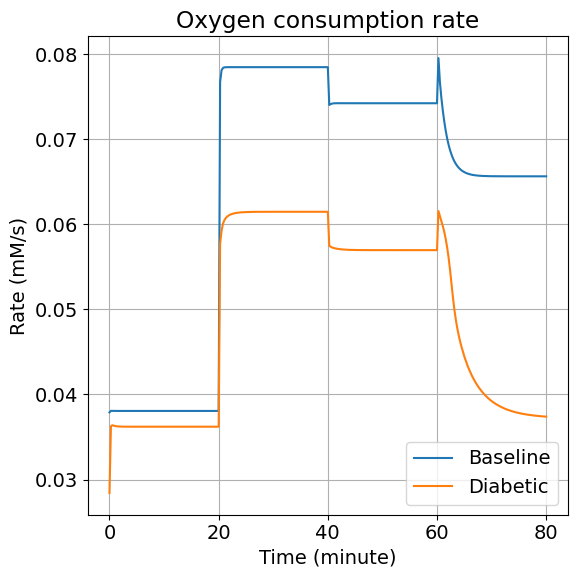

In [15]:
figs4 = plot_jo2(sols3, solDMs3, tspan=(0.0, tend))

In [16]:
# Uncomment if pdf file is required
figs4.savefig("FigS4.tif", dpi=300, format="tiff", pil_kwargs=Dict("compression" => "tiff_lzw"))

## Figure S5

Baseline vs. Diabetic models using Glucose-Oligomycin-Rotenone protocol.

In [17]:
@named sys2 = make_model(;
    glcrhs = add_glucose(t),
    rf1 = add_oligomycin(t),
    retc = add_rotenone(t)
)

Model sys2 with 10 equations
States (10):
  NADH_m(t) [defaults to 0.057]
  NADH_c(t) [defaults to 0.001]
  Ca_m(t) [defaults to 0.0002]
  ΔΨm(t) [defaults to 0.092]
⋮
Parameters (56):
  VmaxGK [defaults to 0.011]
  KglcGK [defaults to 7.0]
  NGK [defaults to 1.7]
  KatpGK [defaults to 0.5]
⋮
Incidence matrix:10×20 SparseArrays.SparseMatrixCSC{Num, Int64} with 61 stored entries:
⡛⣭⠚⣶⠀⠑⢄⠀⠀⠀
⠺⠦⠗⣿⠀⠀⠀⠑⢄⠀
⠀⠛⠀⠛⠛⠀⠀⠀⠀⠑

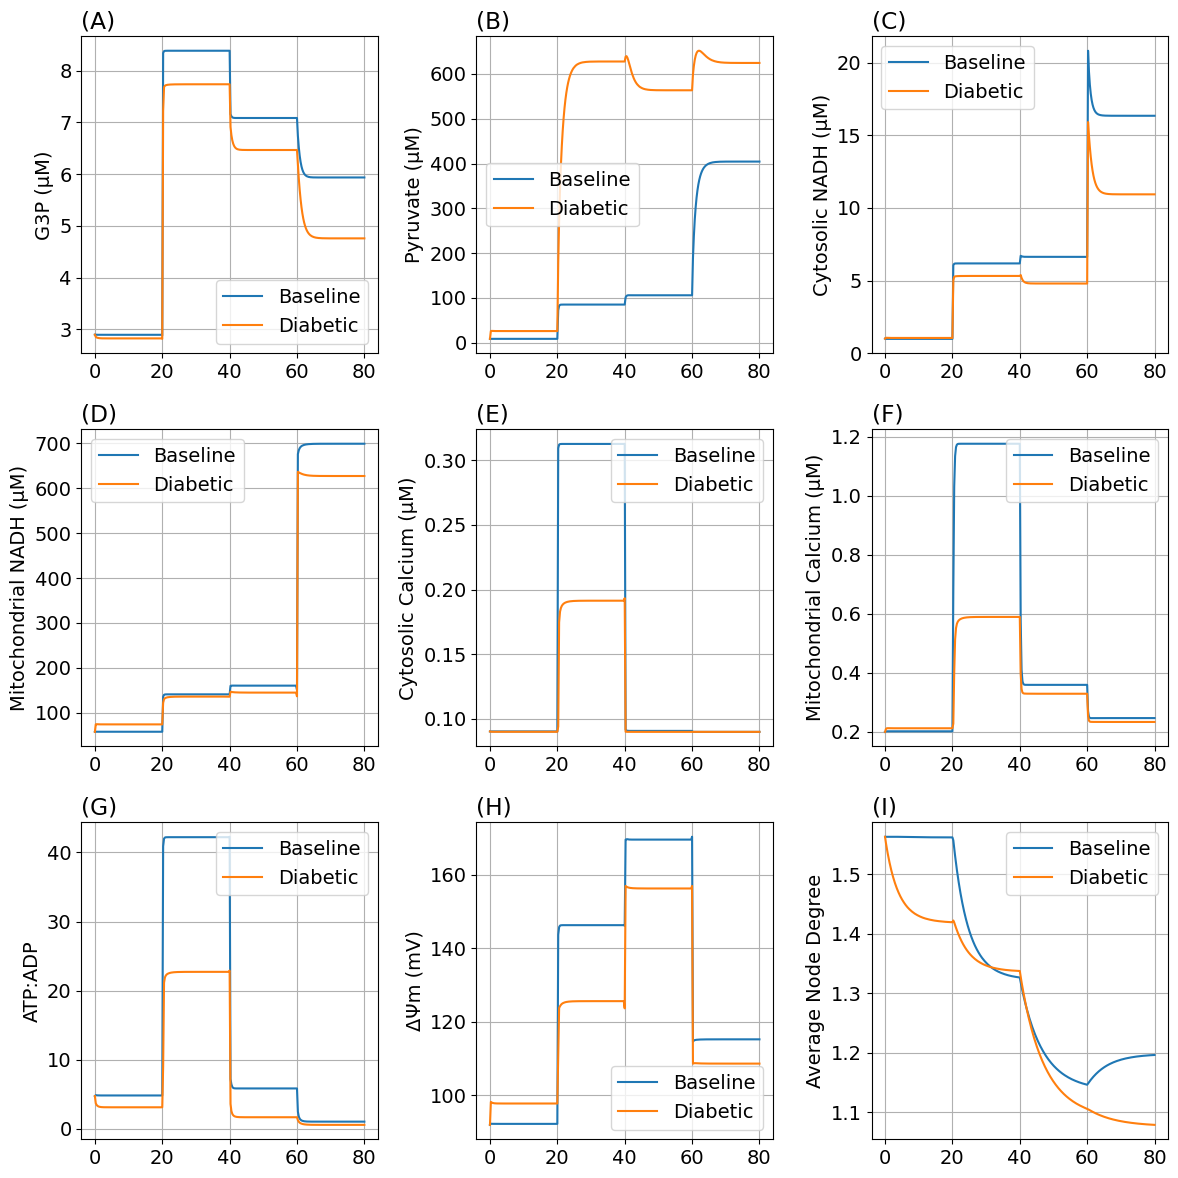

In [18]:
prob2 = ODEProblem(sys2, [], tend)
prob2DM = make_dm_prob(prob2; rPDH=0.5, rETC=0.75, rHL=1.4, rF1=0.5)
sols5 = solve(prob2)
sols5DM = solve(prob2DM)

figs5 = plot_figs2(sols5, sols5DM; tspan=(0.0, tend))

In [19]:
# Uncomment if pdf file is required
figs5.savefig("FigS5.tif", dpi=300, format="tiff", pil_kwargs=Dict("compression" => "tiff_lzw"))

## Figure S6

Oxygen consumption of Baseline and Diabetic models using the protocol from Figure S5.

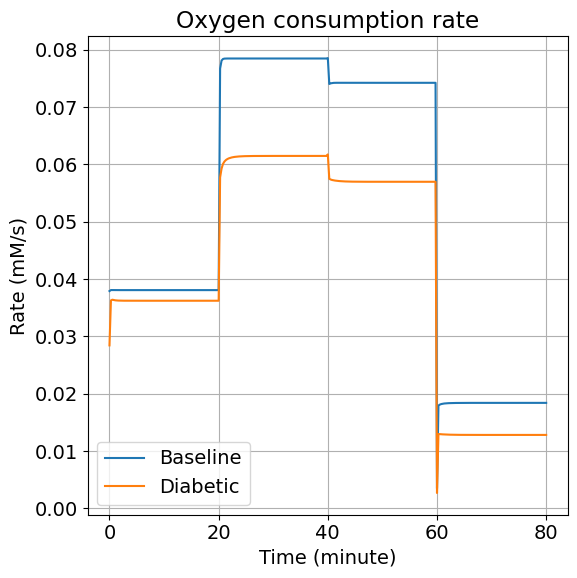

In [20]:
figs6 = plot_jo2(sols5, sols5DM)

In [21]:
# Uncomment if pdf file is required
figs6.savefig("FigS6.tif", dpi=300, format="tiff", pil_kwargs=Dict("compression" => "tiff_lzw"))